## MNIST Classification using PyTorch
Implement a CNN model in PyTorch to classify MNIST dataset, you can use sklearn library to import the mnist dataset.

In [1]:
# Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Start by scratch :)

torch.manual_seed(42)
mnist = fetch_openml(name='mnist_784', version=1, parser='auto')
mnist_data, mnist_labels = mnist.data.astype('float32'), mnist.target.astype('int64')

mnist_data /= 255.0

train_data, val_data, train_labels, val_labels = train_test_split(
    mnist_data, mnist_labels, stratify=mnist_labels, test_size=0.1, random_state=42
)

train_data_np = train_data.to_numpy(dtype='float32')
val_data_np = val_data.to_numpy(dtype='float32')
train_labels_np = train_labels.to_numpy(dtype='int64')
val_labels_np = val_labels.to_numpy(dtype='int64')

train_data = torch.tensor(train_data_np)
val_data = torch.tensor(val_data_np)
train_labels = torch.tensor(train_labels_np)
val_labels = torch.tensor(val_labels_np)

train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_data)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for batch_data, batch_labels in val_loader:
            output = model(batch_data)
            loss = criterion(output, batch_labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

torch.save(model.state_dict(), 'mnist_cnn_model.pth')


Epoch [1/10], Loss: 0.0046, Validation Accuracy: 98.09%
Epoch [2/10], Loss: 0.0011, Validation Accuracy: 98.50%
Epoch [3/10], Loss: 0.0009, Validation Accuracy: 98.64%
Epoch [4/10], Loss: 0.0042, Validation Accuracy: 98.99%
Epoch [5/10], Loss: 0.0008, Validation Accuracy: 99.11%
Epoch [6/10], Loss: 0.0014, Validation Accuracy: 98.87%
Epoch [7/10], Loss: 0.0010, Validation Accuracy: 98.90%
Epoch [8/10], Loss: 0.0001, Validation Accuracy: 98.97%
Epoch [9/10], Loss: 0.0001, Validation Accuracy: 99.01%
Epoch [10/10], Loss: 0.0003, Validation Accuracy: 98.90%


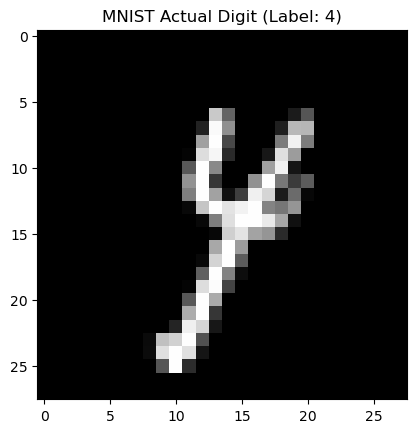

Predicted Label: 4


In [8]:
loaded_model = CNNModel()
loaded_model.load_state_dict(torch.load('mnist_cnn_model.pth'))
loaded_model.eval()

index = np.random.randint(len(val_data))
new_data = val_data[index:index+1]  

image = new_data.reshape(28, 28)
plt.imshow(image, cmap='gray')
plt.title(f'MNIST Actual Digit (Label: {val_labels[index]})')
plt.show()

with torch.no_grad():
    output = loaded_model(new_data.clone().detach().requires_grad_(True))
    predicted_label = torch.argmax(output).item()

print(f'Predicted Label: {predicted_label}')
